In [3]:
import xarray as xr
import numpy as np
import his_utils
import pandas as pd
import os
import itertools
from concurrent.futures import ProcessPoolExecutor, as_completed

# input_data = xr.open_dataset('testdata/2021-06-21/ERA5_input.nc')
# input_data["2m_temperature"].isel(time=0).plot(figsize=(20, 10))
# list(input_data.data_vars)

In [10]:
scales = [0.001, 1]
INTMAX = np.finfo(np.float32).max

ten_persent = 103680

variables = ['10m_u_component_of_wind',
 '10m_v_component_of_wind',
 '2m_temperature',
 'mean_sea_level_pressure',
 'total_precipitation_6hr',
 'geopotential',
 'specific_humidity',
 'temperature',
 'u_component_of_wind',
 'v_component_of_wind',
 'vertical_velocity']

def binary_string(combo):
    # Convert the selected combination to a binary string
    return ''.join(['1' if var in combo else '0' for var in variables])

# Step 1: Select 1 or 2 variables
one_two_variable_combinations = []
for r in [1, 2]:
    one_two_variable_combinations += list(itertools.combinations(variables, r))

# Step 2: Select all but 1 variable
all_but_one_variable_combinations = list(itertools.combinations(variables, len(variables) - 1))

# Step 3: Select all variables
all_variable_combination = [tuple(variables)]  # All variables selected

# Combine all cases
selected_combinations = one_two_variable_combinations + all_but_one_variable_combinations + all_variable_combination


for combo in reversed(selected_combinations):
    combo_string = binary_string(combo)
    print(combo_string)

11111111111
01111111111
10111111111
11011111111
11101111111
11110111111
11111011111
11111101111
11111110111
11111111011
11111111101
11111111110
00000000011
00000000101
00000000110
00000001001
00000001010
00000001100
00000010001
00000010010
00000010100
00000011000
00000100001
00000100010
00000100100
00000101000
00000110000
00001000001
00001000010
00001000100
00001001000
00001010000
00001100000
00010000001
00010000010
00010000100
00010001000
00010010000
00010100000
00011000000
00100000001
00100000010
00100000100
00100001000
00100010000
00100100000
00101000000
00110000000
01000000001
01000000010
01000000100
01000001000
01000010000
01000100000
01001000000
01010000000
01100000000
10000000001
10000000010
10000000100
10000001000
10000010000
10000100000
10001000000
10010000000
10100000000
11000000000
00000000001
00000000010
00000000100
00000001000
00000010000
00000100000
00001000000
00010000000
00100000000
01000000000
10000000000


In [ ]:

# Loop through selected combinations
for combo in selected_combinations:
    combo_string = binary_string(combo, len(variables))

    for region_name, region_bounds in his_utils.REGION_BOUNDARIES.items():
        for wipe_out in True:
            # Determine scale values based on wipe_out
            scale_values = [-INTMAX, INTMAX] if wipe_out else scales

            for scale in scale_values:
                # Generate a descriptive filename
                wipeout_str = "wipeout" if wipe_out else "scale"
                filename = f"ERA5_{combo_string}_{region_name}_{wipeout_str}_{scale}.nc"
                if os.path.exists(os.path.join('/geodata2/S2S/DL/GC_input/2021-06-21/', filename)):
                    print(f"Skipping: {filename}")
                    continue

                # Apply the perturbation to the dataset
                dataset = xr.open_dataset('/geodata2/S2S/DL/GC_input/2021-06-21/ERA5_input.nc')
                perturbed_dataset = his_utils.add_region_specific_perturbation(
                    dataset, selected_variables, scale, perturb_timestep=[0, 1], 
                    region_list=[region_name], wipe_out=wipe_out
                )

                # Save to a new file
                output_path = os.path.join('testdata/2021-06-21/', filename)
                perturbed_dataset.to_netcdf(output_path)
                print(f"Created: {filename}")

# for scale in perturbations:
#     new_data = his_utils.add_Gaussian_perturbation(input_data,
#                                             ['2m_temperature',
#                                              '10m_u_component_of_wind',
#                                              '10m_v_component_of_wind',
#                                              'mean_sea_level_pressure'], 
#                                              scale)
#     new_data.to_netcdf(f'testdata/2021-06-21/ERA5_4var_{scale}std.nc')
# new_data = his_utils.add_Gaussian_perturbation(input_data,
#                                             ['2m_temperature',
#                                              '10m_u_component_of_wind',
#                                              '10m_v_component_of_wind',
#                                              'mean_sea_level_pressure'], 
#                                              1)


# data = his_utils.add_region_specific_perturbation(
#     xr.open_dataset('testdata/2021-06-21/ERA5_input.nc'),
#     ['2m_temperature'],
#     0,
#     [0, 1],
#     ["AusNZ"],
#     True
# )


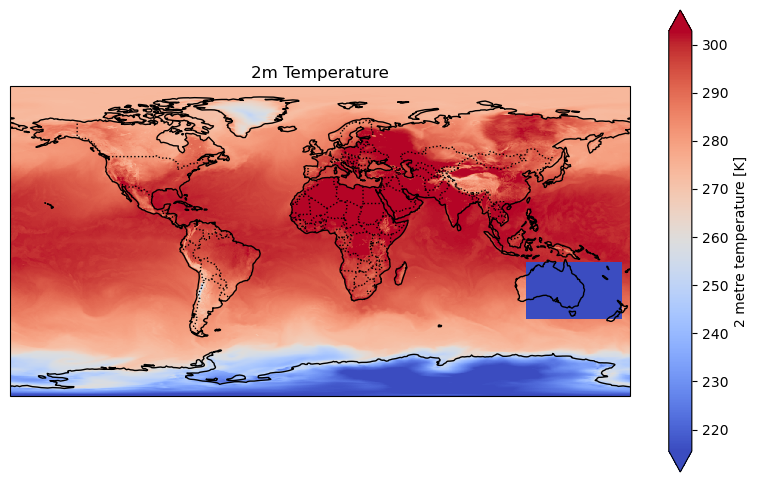

In [30]:
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature


plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())

vmin = data["2m_temperature"].isel(time=0).quantile(0.05)
vmax = data["2m_temperature"].isel(time=0).quantile(0.95)

data["2m_temperature"].isel(time=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax
)

# 지도에 해안선과 국가 경계를 추가합니다.
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# 제목과 기타 설정을 추가합니다.
plt.title('2m Temperature')
plt.show()

---

In [ ]:
variables = ['2m_temperature',
 '10m_u_component_of_wind',
 '10m_v_component_of_wind',
 'mean_sea_level_pressure']
scale = 1
perturb_timestep = [0, 1]
with xr.open_dataset(f'testdata/stats/40yr_std_daily_4var.nc') as std: 
    for i in perturb_timestep:
        idx_time = input_data.time.isel(time=0).values.astype(np.int64)//21600
        normal_dist = np.random.normal(loc=0, scale=1, size=input_data[variables[0]].isel(time=i).shape)
        normal_dist = xr.DataArray(
            data=normal_dist,
            dims=('lat','lon'),
            coords={
                'lat': input_data.lat,
                'lon': input_data.lon
            }
        )
        perturbed = input_data.copy()
 
        for var in variables:
            perturbed.isel(time=i)[var] = input_data[var].isel(time=i) + scale * (normal_dist * std[var].isel(hour=idx_time))
            

    if 'perturbation' in list(perturbed.data_vars):
        perturbed = perturbed.drop_vars('perturbation')
perturbed



In [ ]:
xr.open_dataset(f'testdata/2021-06-21/ERA5_input.nc')

# Scratch Codes

In [ ]:

# 5x5 numpy 배열 생성
data = np.arange(9).reshape(3,3)

# xarray DataArray 생성
da = xr.DataArray(
    data,
    dims=("latitude", "longitude"),  # 차원 이름 지정
    coords={
        "latitude": np.linspace(35, 39, 3),  # y 좌표
        "longitude": np.linspace(125, 129, 3) # x 좌표
    },
    name="example_data"  # DataArray의 이름
)

# 5x5 numpy 배열 생성
data = np.random.uniform(low=0, high=10, size=(3, 3))
data = np.round(data, decimals=0)

# xarray DataArray 생성
da2 = xr.DataArray(
    data,
    dims=("latitude", "longitude"),  # 차원 이름을 위도와 경도로 지정
    coords={
        "latitude": np.linspace(35, 39, 3),   # 위도 좌표 (35도에서 39도)
        "longitude": np.linspace(125, 129, 3) # 경도 좌표 (125도에서 129도)
    },
    name="temperature"  # DataArray의 이름을 temperature로 지정
)

data = np.random.uniform(low=0, high=10, size=(3, 3))
data = np.round(data, decimals=0)

# xarray DataArray 생성
da3 = xr.DataArray(
    data,
    dims=("latitude", "longitude"),  # 차원 이름을 위도와 경도로 지정
    coords={
        "latitude": np.linspace(35, 39, 3),   # 위도 좌표 (35도에서 39도)
        "longitude": np.linspace(125, 129, 3) # 경도 좌표 (125도에서 129도)
    },
    name="temperature"  # DataArray의 이름을 temperature로 지정
)

print(da)
print(da2)
print(da3)

da + 0.1 * (da2 * da3)

In [ ]:
dataset_21 = xr.open_dataset('testdata/2021-06-21/ERA5_4var_1std.nc')
dataset_26 = xr.open_dataset('testdata/2021-06-26/ERA5_4var_1std.nc')
dataset_21

In [ ]:
dataset_26